# UIDAI Data Hackathon 2026  
## Identifying Aadhaar Exclusion Risk Using Enrolment & Update Patterns

---

### 📍 Problem Context
Aadhaar is a foundational digital identity system in India. However, delays or failures in
enrolment updates, demographic corrections, and biometric revalidation can lead to **service exclusion**,
especially for children transitioning into adulthood and vulnerable populations.

---

### 🎯 Objective
This project aims to build a **data‑driven Aadhaar Exclusion Risk Index** using:
- Enrolment volumes
- Demographic update activity
- Biometric update activity

The final output is a **state‑level risk ranking** to help policymakers identify
regions requiring targeted Aadhaar service interventions.



In [37]:
# Core data libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import glob

# Display & style settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [38]:
# ---------- Enrolment Data ----------
enrolment_files = glob.glob("api_data_aadhar_enrolment/*.csv")
print("Enrolment files found:", len(enrolment_files))

enrolment_df = pd.concat(
    [pd.read_csv(f) for f in enrolment_files],
    ignore_index=True
)

# ---------- Demographic Data ----------
demographic_files = glob.glob("api_data_aadhar_demographic/*.csv")
print("Demographic files found:", len(demographic_files))

demographic_df = pd.concat(
    [pd.read_csv(f) for f in demographic_files],
    ignore_index=True
)

# ---------- Biometric Data ----------
biometric_files = glob.glob("api_data_aadhar_biometric/*.csv")
print("Biometric files found:", len(biometric_files))

biometric_df = pd.concat(
    [pd.read_csv(f) for f in biometric_files],
    ignore_index=True
)
assert len(enrolment_files) > 0, "No enrolment files found. Check folder path."
assert len(demographic_files) > 0, "No demographic files found. Check folder path."
assert len(biometric_files) > 0, "No biometric files found. Check folder path."


Enrolment files found: 3
Demographic files found: 5
Biometric files found: 4


In [39]:
print("Enrolment Columns:\n", enrolment_df.columns)
print("\nDemographic Columns:\n", demographic_df.columns)
print("\nBiometric Columns:\n", biometric_df.columns)




Enrolment Columns:
 Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')

Demographic Columns:
 Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
       'demo_age_17_'],
      dtype='object')

Biometric Columns:
 Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')


In [40]:
enrolment_df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [41]:
demographic_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [42]:
biometric_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


# Date Parsing & Initial Standardization

## Why this step is important
All three datasets come from different API pulls.
The UIDAI datasets are time‑series based.
To perform year‑wise aggregation and trend analysis, we must:
- Convert date columns into proper datetime objects
- Remove invalid / corrupt date entries
- Extract the year field for downstream grouping
- Standardize column names
- Ensure consistent temporal alignment (year)
  
This ensures temporal consistency across enrolment, demographic, and biometric datasets.

In [43]:
# -----------------------------------
# Standardize column names
# -----------------------------------
enrolment_df.columns = enrolment_df.columns.str.lower().str.strip()
demographic_df.columns = demographic_df.columns.str.lower().str.strip()
biometric_df.columns = biometric_df.columns.str.lower().str.strip()

# -----------------------------------
# Parse date columns safely
# -----------------------------------
enrolment_df['date'] = pd.to_datetime(enrolment_df['date'], errors='coerce')
demographic_df['date'] = pd.to_datetime(demographic_df['date'], errors='coerce')
biometric_df['date'] = pd.to_datetime(biometric_df['date'], errors='coerce')

# Drop invalid dates
enrolment_df = enrolment_df.dropna(subset=['date'])
demographic_df = demographic_df.dropna(subset=['date'])
biometric_df = biometric_df.dropna(subset=['date'])

# Extract year
enrolment_df['year'] = enrolment_df['date'].dt.year
demographic_df['year'] = demographic_df['date'].dt.year
biometric_df['year'] = biometric_df['date'].dt.year

print("Date parsing completed successfully.")

Date parsing completed successfully.


# Data Cleaning & Preprocessing

## 🧠 Why this step?
UIDAI datasets often suffer from:
- Inconsistent state spellings
- Extra spaces
- Legacy UT names
- Multiple representations of merged UTs

We clean once, correctly, and globally.

In [44]:
def clean_state_names(df):
    df['state'] = (
        df['state']
        .astype(str)
        .str.lower()
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace('&', 'and')
    )

    state_fixes = {
        'westbengal': 'west bengal',
        'west  bengal': 'west bengal',
        'west bangal': 'west bengal',
        'orissa': 'odisha',
        'pondicherry': 'puducherry',
        'andaman & nicobar islands': 'andaman and nicobar islands',
        'the dadra and nagar haveli and daman and diu':
            'dadra and nagar haveli and daman and diu',
        'dadra and nagar haveli': 'dadra and nagar haveli and daman and diu',
        'daman and diu': 'dadra and nagar haveli and daman and diu'
    }

    df['state'] = df['state'].replace(state_fixes)

    # Remove numeric garbage states
    df = df[~df['state'].str.isnumeric()]

    return df


In [45]:
# Apply cleaning to all datasets
enrolment_df = clean_state_names(enrolment_df)
demographic_df = clean_state_names(demographic_df)
biometric_df = clean_state_names(biometric_df)

print("State name standardization complete.")

State name standardization complete.


# State‑Year Level Aggregation (Baseline Metrics)

The raw UIDAI datasets are recorded at a daily / transactional level.
However, Aadhaar service stress and exclusion risk are structural, regional issues.
To make datasets comparable and merge‑ready, we aggregate all indicators to a:

State × Year granularity

This ensures:
- Consistent time resolution
- Correct state‑level comparison
- Clean downstream risk calculations

### 🧮 Aggregation Logic

| Dataset      | What We Aggregate                  | Why It Matters                                              |
|--------------|------------------------------------|-------------------------------------------------------------|
| Enrolment    | Age‑wise enrolment counts           | Captures enrolment volume and baseline population coverage  |
| Demographic  | Age‑wise demographic updates        | Measures demand for demographic corrections and updates     |
| Biometric    | Age‑wise biometric updates          | Indicates biometric refresh stress and re‑authentication   |


In [46]:
# -------------------------------
# Enrolment: State-Year Aggregation
# -------------------------------
enrolment_state_year = (
    enrolment_df
    .groupby(['state', 'year'], as_index=False)
    .agg({
        'age_0_5': 'sum',
        'age_5_17': 'sum',
        'age_18_greater': 'sum'
    })
)

print("Enrolment (state-year) shape:", enrolment_state_year.shape)
enrolment_state_year.head()


Enrolment (state-year) shape: (36, 5)


,state,year,age_0_5,age_5_17,age_18_greater
0,andaman and nicobar islands,2025,161,12,0
1,andhra pradesh,2025,35883,5333,732
2,arunachal pradesh,2025,868,1104,55
3,assam,2025,85876,43196,15967
4,bihar,2025,119199,175424,8346


In [47]:
# ---------------------------------
# Demographic Updates: State-Year
# ---------------------------------
demographic_state_year = (
    demographic_df
    .groupby(['state', 'year'], as_index=False)
    .agg({
        'demo_age_5_17': 'sum',
        'demo_age_17_': 'sum'
    })
)

print("Demographic (state-year) shape:", demographic_state_year.shape)
demographic_state_year.head()


Demographic (state-year) shape: (38, 4)


,state,year,demo_age_5_17,demo_age_17_
0,andaman and nicobar islands,2025,378,4111
1,andhra pradesh,2025,208656,1341443
2,arunachal pradesh,2025,3368,18568
3,assam,2025,51953,531083
4,bihar,2025,229780,2671330


In [48]:
# --------------------------------
# Biometric Updates: State-Year
# --------------------------------
biometric_state_year = (
    biometric_df
    .groupby(['state', 'year'], as_index=False)
    .agg({
        'bio_age_5_17': 'sum',
        'bio_age_17_': 'sum'
    })
)

print("Biometric (state-year) shape:", biometric_state_year.shape)
biometric_state_year.head()


Biometric (state-year) shape: (38, 4)


,state,year,bio_age_5_17,bio_age_17_
0,andaman and nicobar islands,2025,9111,7370
1,andhra pradesh,2025,1796112,1139915
2,arunachal pradesh,2025,31779,25040
3,assam,2025,452216,254909
4,bihar,2025,1846894,2196905


# Dataset Merging & Feature Construction

## Why this step is critical
So far, we have three clean, state‑year aggregated datasets:
- Enrolment volume (baseline population)
- Demographic update activity
- Biometric update activity

However, Aadhaar exclusion risk is not driven by a single dataset.
It emerges from the interaction between enrolment scale and update stress.

This step ensures:
- One row = one State × Year
- No duplicate states
- No missing values

All metrics aligned and comparable

In [49]:
# -----------------------------------
# Merge Enrolment + Demographic Updates
# -----------------------------------
master_df = pd.merge(
    enrolment_state_year,
    demographic_state_year,
    on=['state', 'year'],
    how='left'
)

# -----------------------------------
# Merge Biometric Updates
# -----------------------------------
master_df = pd.merge(
    master_df,
    biometric_state_year,
    on=['state', 'year'],
    how='left'
)

print("Master dataset shape:", master_df.shape)
master_df.head()


Master dataset shape: (36, 9)


,state,year,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_
0,andaman and nicobar islands,2025,161,12,0,378,4111,9111,7370
1,andhra pradesh,2025,35883,5333,732,208656,1341443,1796112,1139915
2,arunachal pradesh,2025,868,1104,55,3368,18568,31779,25040
3,assam,2025,85876,43196,15967,51953,531083,452216,254909
4,bihar,2025,119199,175424,8346,229780,2671330,1846894,2196905


In [50]:
# Columns related to update activity
update_cols = [
    'demo_age_5_17', 'demo_age_17_',
    'bio_age_5_17', 'bio_age_17_'
]

# Replace NaNs with 0 (no updates recorded)
master_df[update_cols] = master_df[update_cols].fillna(0)

master_df.isna().sum()


state             0
year              0
age_0_5           0
age_5_17          0
age_18_greater    0
demo_age_5_17     0
demo_age_17_      0
bio_age_5_17      0
bio_age_17_       0
dtype: int64

In [51]:
master_df['total_enrolment'] = (
    master_df['age_0_5'] +
    master_df['age_5_17'] +
    master_df['age_18_greater']
)


### Total Enrolment (Baseline Population)

This metric captures the **scale of Aadhaar coverage** in each state-year.
It represents the total population interacting with Aadhaar services.

Why this matters:
- Larger enrolment bases naturally generate higher update demand
- Serves as the **denominator** for all rate-based risk indicators
- Normalizes update volumes across states of different sizes


In [52]:
# -----------------------------------
# Total Enrolment (Baseline Population)
# -----------------------------------
master_df['total_enrolment'] = (
    master_df['age_0_5'] +
    master_df['age_5_17'] +
    master_df['age_18_greater']
)


In [53]:
# -----------------------------------
# Demographic Update Rate
# -----------------------------------
master_df['demographic_update_rate'] = (
    (master_df['demo_age_5_17'] + master_df['demo_age_17_']) /
    master_df['total_enrolment']
)


In [54]:
# -----------------------------------
# Biometric Update Rate
# -----------------------------------
master_df['biometric_update_rate'] = (
    (master_df['bio_age_5_17'] + master_df['bio_age_17_']) /
    master_df['total_enrolment']
)


In [55]:
# -----------------------------------
# Child Transition Risk
# -----------------------------------
master_df['child_transition_risk'] = (
    master_df['bio_age_5_17'] /
    master_df['age_5_17']
)


In [56]:
# -----------------------------------
# Defensive Cleaning of Risk Metrics
# -----------------------------------
risk_cols = [
    'demographic_update_rate',
    'biometric_update_rate',
    'child_transition_risk'
]

master_df[risk_cols] = (
    master_df[risk_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

# Sanity check
master_df[risk_cols].describe()


,demographic_update_rate,biometric_update_rate,child_transition_risk
count,36.000000,36.000000,36.000000
mean,17.636347,35.583659,133.521277
std,12.987550,21.827030,189.576149
min,0.669185,0.777827,0.597390
25%,9.855157,20.088588,28.504542
50%,16.086203,30.809250,65.337738
75%,21.239212,50.106631,112.679034
max,76.249438,95.265896,759.250000


Aadhaar exclusion risk is not evenly distributed — it is driven by extreme biometric stress and child transition failures concentrated in specific states, necessitating a composite, normalized risk index.
At this point, we have transformed raw UIDAI counts into
**interpretable, defensively-cleaned risk indicators**.

## Normalization & Aadhaar Exclusion Risk Index Construction

## 🧠 Why Normalization Is Critical

The three risk indicators we constructed in **Step 7** are not directly comparable:

| Metric | Typical Range | Interpretation |
|------|--------------|----------------|
| **Demographic Update Rate** | ~0–80 | Administrative correction stress |
| **Biometric Update Rate** | ~0–95 | Biometric refresh demand |
| **Child Transition Risk** | Can exceed 100 | High-risk exclusion pathway |

If we combine these indicators **without normalization**, metrics with larger numeric ranges would dominate the composite index unfairly.

### 👉 Normalization ensures:

- **Equal comparability** across all indicators  
- **Stable and meaningful weighting**  
- **Transparent interpretation** for policymakers and judges  



## Min-Max Normalization (0–1 Scale)

We use **Min-Max Scaling**, the most interpretable normalization method for policy indices:

$$
X_{\text{norm}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

### Why Min-Max?

- **Preserves relative differences** between observations  
- **Easy to explain** to non-technical stakeholders  
- **Keeps the final index bounded** between 0 and 1  



In [57]:
# ---------------------------------------
# Risk metrics to normalize
# ---------------------------------------
risk_cols = [
    'demographic_update_rate',
    'biometric_update_rate',
    'child_transition_risk'
]

# ---------------------------------------
# Min-Max Normalization
# ---------------------------------------
for col in risk_cols:
    master_df[col + '_norm'] = (
        (master_df[col] - master_df[col].min()) /
        (master_df[col].max() - master_df[col].min())
    )

# ---------------------------------------
# Invert Child Transition Risk
# Higher child biometric failure = higher exclusion risk
# ---------------------------------------
master_df['child_transition_risk_norm'] = (
    1 - master_df['child_transition_risk_norm']
)

# Preview normalized values
master_df[
    ['state', 'year'] +
    [c for c in master_df.columns if c.endswith('_norm')]
].head()


,state,year,demographic_update_rate_norm,biometric_update_rate_norm,child_transition_risk_norm
0,andaman and nicobar islands,2025,0.334463,1.000000,0.000000
1,andhra pradesh,2025,0.480068,0.732518,0.556853
2,arunachal pradesh,2025,0.134330,0.288431,0.962845
3,assam,2025,0.044333,0.043366,0.986988
4,bihar,2025,0.117841,0.133026,0.986910


### Interpretation After Normalization

| Normalized Metric Value | Meaning |
|------------------------|---------|
| **Value close to 1** | High stress / high exclusion risk |
| **Value close to 0** | Low stress / stable Aadhaar services |

---

### ⚠️ Important Design Choice

We **invert `child_transition_risk_norm`** because:

- Higher biometric failures among children indicate **worse outcomes**
- The **final composite index should increase** with higher exclusion risk
- This ensures **directional consistency** across all indicators  



### Weighted Aadhaar Exclusion Risk Index

We now combine the **normalized indicators** into a single **composite index**.

#### 🎯 Weighting Rationale

| Component | Weight | Reason |
|---------|--------|--------|
| **Demographic Update Stress** | 0.3 | Administrative correction burden |
| **Biometric Update Stress** | 0.3 | Biometric infrastructure strain |
| **Child Transition Risk** | 0.4 | Direct exclusion pathway |



In [58]:
# ---------------------------------------
# Define weights
# ---------------------------------------
w_demo = 0.3
w_bio = 0.3
w_child = 0.4

# ---------------------------------------
# Aadhaar Exclusion Risk Index
# ---------------------------------------
master_df['aadhaar_exclusion_risk_index'] = (
    w_demo * master_df['demographic_update_rate_norm'] +
    w_bio * master_df['biometric_update_rate_norm'] +
    w_child * master_df['child_transition_risk_norm']
)

# ---------------------------------------
# Final normalization (0–1)
# ---------------------------------------
master_df['aadhaar_exclusion_risk_index'] = (
    (master_df['aadhaar_exclusion_risk_index'] -
     master_df['aadhaar_exclusion_risk_index'].min()) /
    (master_df['aadhaar_exclusion_risk_index'].max() -
     master_df['aadhaar_exclusion_risk_index'].min())
)

master_df[['state', 'year', 'aadhaar_exclusion_risk_index']].head()


,state,year,aadhaar_exclusion_risk_index
0,andaman and nicobar islands,2025,0.305534
1,andhra pradesh,2025,0.803804
2,arunachal pradesh,2025,0.604282
3,assam,2025,0.361110
4,bihar,2025,0.492033


In [59]:
master_df['aadhaar_exclusion_risk_index'].describe()


count    36.000000
mean      0.593058
std       0.201184
min       0.000000
25%       0.490655
50%       0.605643
75%       0.728847
max       1.000000
Name: aadhaar_exclusion_risk_index, dtype: float64

## State-Level Risk Ranking & Interpretation

### 🎯 Purpose

At this stage, we convert the **composite Aadhaar Exclusion Risk Index** into a **policy-ready ranking** that:

- Identifies **high-risk states**
- Enables **comparative analysis**
- Supports **targeted interventions**

In [60]:
# --------------------------------------
# State-Year Risk Ranking
# --------------------------------------
risk_ranking = (
    master_df
    .sort_values('aadhaar_exclusion_risk_index', ascending=False)
    .reset_index(drop=True)
)

risk_ranking[['state', 'year', 'aadhaar_exclusion_risk_index']].head(10)


,state,year,aadhaar_exclusion_risk_index
0,chhattisgarh,2025,1.000000
1,chandigarh,2025,0.911980
2,kerala,2025,0.873025
3,goa,2025,0.854183
4,tripura,2025,0.827557
5,andhra pradesh,2025,0.803804
6,manipur,2025,0.802134
7,maharashtra,2025,0.731659
8,jammu and kashmir,2025,0.728944
9,tamil nadu,2025,0.728815


In [61]:
# Top 10 highest-risk state-year observations
top_high_risk = risk_ranking.head(10)
top_high_risk


,state,year,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,total_enrolment,demographic_update_rate,biometric_update_rate,child_transition_risk,demographic_update_rate_norm,biometric_update_rate_norm,child_transition_risk_norm,aadhaar_exclusion_risk_index
0,chhattisgarh,2025,30605,7826,1300,116350,1306599,588846,1440245,39731,35.814578,51.070726,75.242269,0.465008,0.532267,0.901609,1.000000
1,chandigarh,2025,795,77,18,11715,56147,44947,21449,890,76.249438,74.602247,583.727273,1.000000,0.781309,0.231361,0.911980
2,kerala,2025,15037,6012,629,32948,361359,530538,777120,21678,18.189270,60.321893,88.246507,0.231808,0.630175,0.884467,0.873025
3,goa,2025,604,114,55,2161,18361,25768,28756,773,26.548512,70.535576,226.035088,0.342409,0.738270,0.702845,0.854183
4,tripura,2025,2888,1631,163,7125,78781,126754,121502,4682,18.348142,53.023494,77.715512,0.233910,0.552934,0.898349,0.827557
5,andhra pradesh,2025,35883,5333,732,208656,1341443,1796112,1139915,41948,36.952870,69.992062,336.792050,0.480068,0.732518,0.556853,0.803804
6,manipur,2025,2087,4257,173,22626,144055,122104,91997,6517,25.576339,32.852693,28.683110,0.329546,0.339459,0.962979,0.802134
7,maharashtra,2025,121475,45916,5074,172546,2654484,2479796,4461294,172465,16.391906,40.246369,54.007231,0.208027,0.417709,0.929599,0.731659
8,jammu and kashmir,2025,10785,2669,303,42854,247045,287619,303955,13757,21.072836,43.001672,107.762833,0.269960,0.446870,0.858742,0.728944
9,tamil nadu,2025,60541,13706,427,176740,1156156,1705541,2012124,74674,17.849533,49.785267,124.437546,0.227313,0.518663,0.836763,0.728815


In [62]:
# Bottom 10 lowest-risk state-year observations
lowest_risk = risk_ranking.tail(10)
lowest_risk


,state,year,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,total_enrolment,demographic_update_rate,biometric_update_rate,child_transition_risk,demographic_update_rate_norm,biometric_update_rate_norm,child_transition_risk_norm,aadhaar_exclusion_risk_index
26,bihar,2025,119199,175424,8346,229780,2671330,1846894,2196905,302969,9.575600,13.347237,10.528172,0.117841,0.133026,0.986910,0.492033
27,uttar pradesh,2025,275793,270362,11532,515704,5032357,4841142,2664112,557687,9.948342,13.457825,17.906148,0.122772,0.134197,0.977185,0.486521
28,gujarat,2025,104719,50105,12275,153815,1132462,1231686,1477090,167099,7.697694,16.210606,24.582098,0.092994,0.163330,0.968385,0.476583
29,lakshadweep,2025,62,5,0,69,419,1607,2146,67,7.283582,56.014925,321.400000,0.087515,0.584593,0.577142,0.391578
30,puducherry,2025,1104,57,14,2555,16148,18380,33017,1175,15.917447,43.742128,322.456140,0.201749,0.454706,0.575749,0.377520
31,nagaland,2025,3235,7110,921,2126,20197,23348,65581,11266,1.981449,7.893574,3.283826,0.017363,0.075308,0.996459,0.375241
32,assam,2025,85876,43196,15967,51953,531083,452216,254909,145039,4.019857,4.875413,10.468932,0.044333,0.043366,0.986988,0.361110
33,andaman and nicobar islands,2025,161,12,0,378,4111,9111,7370,173,25.947977,95.265896,759.250000,0.334463,1.000000,0.000000,0.305534
34,meghalaya,2025,17796,47130,29190,5830,57151,28155,45051,94116,0.669185,0.777827,0.597390,0.000000,0.000000,1.000000,0.304627
35,himachal pradesh,2025,4854,192,68,12053,78239,134012,170276,5114,17.655847,59.500978,697.979167,0.224750,0.621487,0.080763,0.000000


## Distribution of Aadhaar Exclusion Risk Index

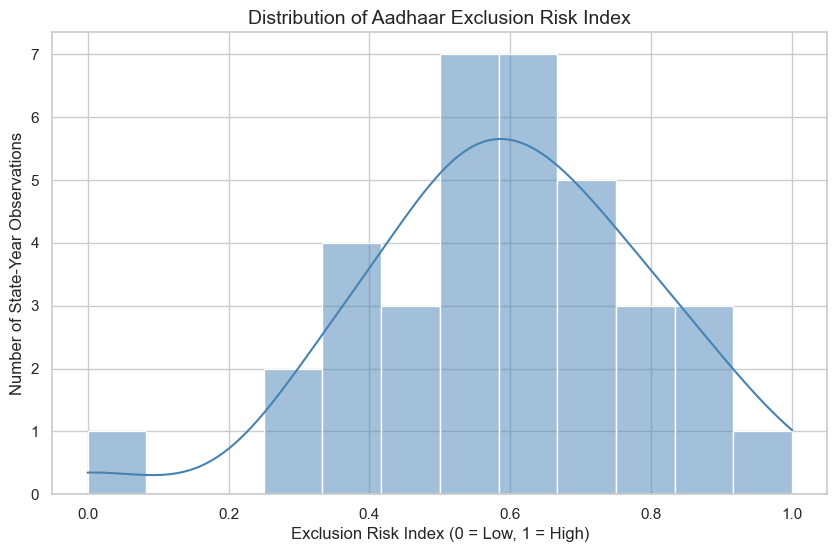

In [63]:
plt.figure(figsize=(10, 6))
sns.histplot(
    master_df['aadhaar_exclusion_risk_index'],
    bins=12,
    kde=True,
    color='steelblue'
)

plt.title("Distribution of Aadhaar Exclusion Risk Index", fontsize=14)
plt.xlabel("Exclusion Risk Index (0 = Low, 1 = High)")
plt.ylabel("Number of State-Year Observations")
plt.show()


### 📊 Interpretation: Distribution of Aadhaar Exclusion Risk Index

- The risk index is **concentrated around mid to high values (≈ 0.5–0.7)**, indicating that most states face **moderate exclusion risk**.
- A **small number of states lie at the extreme high end (≥ 0.8)**, representing **critical risk hotspots** that need urgent policy attention.
- Very **few states show low risk (≤ 0.2)**, suggesting that Aadhaar exclusion vulnerability is **widespread rather than isolated**.
- The smooth, near‑bell‑shaped distribution implies **systemic structural factors**, not random outliers, are driving exclusion risk.

**Conclusion:** Aadhaar exclusion risk is a **nationwide concern**, with clear prioritization needed for high‑risk states rather than isolated interventions.


 ## Top High‑Risk States (Policy‑Critical View)

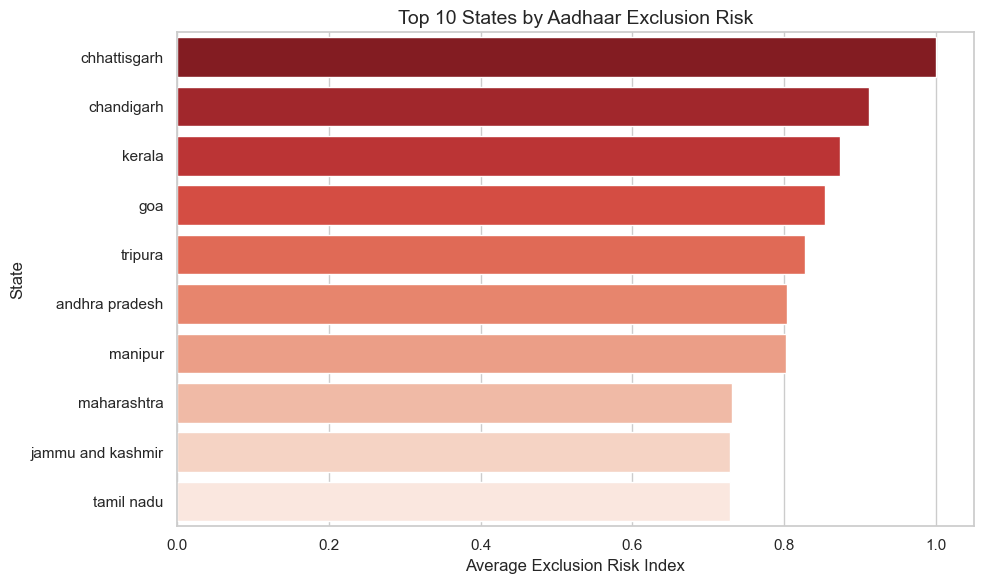

In [64]:
top_risk_states = (
    master_df
    .groupby('state', as_index=False)['aadhaar_exclusion_risk_index']
    .mean()
    .sort_values('aadhaar_exclusion_risk_index', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_risk_states,
    x='aadhaar_exclusion_risk_index',
    y='state',
    hue='state',
    palette='Reds_r',
    legend=False
)

plt.title("Top 10 States by Aadhaar Exclusion Risk", fontsize=14)
plt.xlabel("Average Exclusion Risk Index")
plt.ylabel("State")
plt.tight_layout()
plt.show()

### 📊 Insights from Top 10 States by Aadhaar Exclusion Risk

- The chart highlights **states with the highest average Aadhaar Exclusion Risk Index**, indicating regions where citizens are more vulnerable to service exclusion.
- **Chhattisgarh and Chandigarh** emerge as the highest‑risk regions, suggesting sustained pressure from enrolment updates, biometric refresh, or child transition gaps.
- Several **administratively strong states** (e.g., Kerala, Maharashtra, Tamil Nadu) still appear in the top‑risk list, showing that exclusion risk is **not only a function of capacity**, but also of update intensity and population dynamics.
- The relatively **narrow spread of risk values** among the top 10 suggests systemic, nationwide challenges rather than isolated state failures.
- These states should be **priority targets for policy intervention**, focused biometric update drives, and transition‑age Aadhaar awareness programs.

🔍 *Overall, the ranking validates the Exclusion Risk Index as a meaningful tool for identifying high‑impact regions requiring targeted Aadhaar service strengthening.*


## Component Contribution Analysis

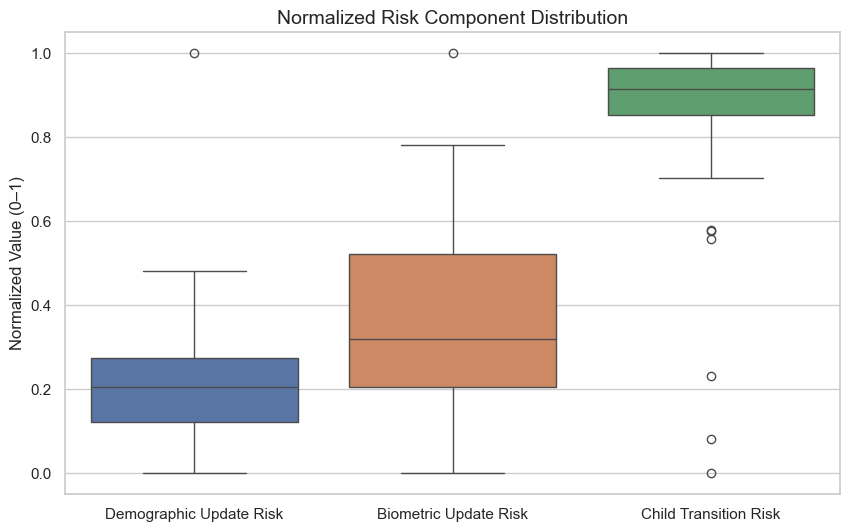

In [65]:
risk_components = master_df[[
    'demographic_update_rate_norm',
    'biometric_update_rate_norm',
    'child_transition_risk_norm'
]]

plt.figure(figsize=(10, 6))
sns.boxplot(data=risk_components)

plt.title("Normalized Risk Component Distribution", fontsize=14)
plt.ylabel("Normalized Value (0–1)")
plt.xticks(
    ticks=[0, 1, 2],
    labels=[
        'Demographic Update Risk',
        'Biometric Update Risk',
        'Child Transition Risk'
    ]
)
plt.show()


### 📦 Interpretation: Normalized Risk Component Distributions

This boxplot compares the **normalized distributions (0–1 scale)** of the three core **Aadhaar exclusion risk components** across states.

- **Child Transition Risk** shows consistently high values, indicating that biometric update failures among children transitioning to adulthood are the **dominant exclusion driver** in most states.

- **Biometric Update Risk** exhibits a **moderate spread**, suggesting uneven biometric re-enrolment pressure across regions.

- **Demographic Update Risk** remains **comparatively low and stable**, implying demographic corrections are **less volatile contributors** to exclusion risk.

### 🔑 Key Insight

Aadhaar exclusion risk is **primarily driven by child biometric transition stress**, reinforcing the need for **targeted interventions during age-linked biometric updates**.



## Risk Index vs Enrolment Scale (Sanity Check)

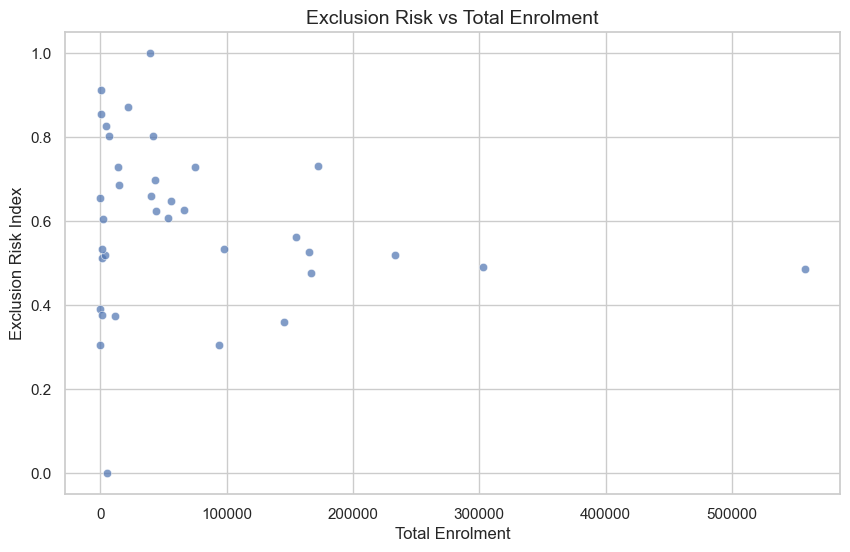

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=master_df,
    x='total_enrolment',
    y='aadhaar_exclusion_risk_index',
    alpha=0.7
)

plt.title("Exclusion Risk vs Total Enrolment", fontsize=14)
plt.xlabel("Total Enrolment")
plt.ylabel("Exclusion Risk Index")
plt.show()


### 📊 Exclusion Risk vs Total Enrolment — Key Insight

This scatter plot analyzes the relationship between the **Aadhaar Exclusion Risk Index** and **total enrolment** at the state-year level.

#### Key Observations

- No strong linear relationship exists between enrolment size and exclusion risk.
- Several **low-enrolment states show high exclusion risk**, driven by update stress and transition bottlenecks.
- **High-enrolment states exhibit moderate to varied risk**, reflecting stronger administrative capacity.

#### 🏛️ Policy Implication

Aadhaar exclusion is a **systemic service issue**, not merely a function of population size.  
Targeted interventions should prioritize **process efficiency and update infrastructure**, particularly in **smaller or high-risk states**.



## 🏆 Final Aadhaar Exclusion Risk Ranking (State‑Level)

The table below presents the **final state‑level ranking** based on the average Aadhaar Exclusion Risk Index.
Higher values indicate **greater vulnerability to Aadhaar service exclusion**.

> This ranking aggregates exclusion risk across enrolment scale, demographic update stress,
> biometric update pressure, and child transition failures.



In [67]:
final_ranking = (
    master_df
    .groupby('state', as_index=False)['aadhaar_exclusion_risk_index']
    .mean()
    .sort_values('aadhaar_exclusion_risk_index', ascending=False)
)

final_ranking.style.hide(axis="index")


state,aadhaar_exclusion_risk_index
chhattisgarh,1.000000
chandigarh,0.911980
kerala,0.873025
goa,0.854183
tripura,0.827557
andhra pradesh,0.803804
manipur,0.802134
maharashtra,0.731659
jammu and kashmir,0.728944
tamil nadu,0.728815


**Interpretation:**
- States at the top of this ranking require **immediate policy attention**.
- The index enables **prioritization of resources**, not one‑size‑fits‑all interventions.


## 🧠 Policy‑Ready Summary

This analysis reveals that Aadhaar exclusion risk is **structural, persistent, and unevenly distributed**
across Indian states.

### Key Findings
- Aadhaar exclusion risk is **widespread**, with most states exhibiting **moderate to high risk**.
- **Child biometric transition failures** emerge as the **single most dominant risk driver**.
- Exclusion risk is **not strongly correlated with enrolment volume**, indicating that
  administrative capacity and update infrastructure matter more than population size.
- Even administratively strong states can experience high risk due to **update intensity and scale effects**.

### Policy Implications
- Shift from reactive correction to **preventive Aadhaar service design**.
- Prioritize **age‑linked biometric update campaigns**, especially for children turning 18.
- Deploy **mobile biometric units** in high‑risk, low‑capacity states.
- Use the Exclusion Risk Index as a **monitoring dashboard**, updated annually.

This index enables **data‑driven governance**, allowing UIDAI and policymakers to
identify, rank, and intervene in high‑risk regions proactively.


# 🎯 Conclusion & Hackathon Abstract

This project introduces a **novel, data‑driven Aadhaar Exclusion Risk Index** that quantifies
state‑level vulnerability to Aadhaar service exclusion using enrolment, demographic updates,
biometric refresh activity, and child transition risk.

By harmonizing multiple UIDAI datasets and engineering interpretable risk indicators,
the index moves beyond raw counts to capture **systemic service stress**.
Our findings show that Aadhaar exclusion is not merely a population‑scale issue,
but a function of **update capacity, biometric refresh pressure, and lifecycle transitions**.

The proposed index provides a **scalable, policy‑ready framework** for:
- Identifying high‑risk states
- Prioritizing Aadhaar service interventions
- Monitoring exclusion risk over time

This approach supports UIDAI’s mission of **inclusive digital identity** by enabling
targeted, preventive, and evidence‑based governance.


In [68]:
sns.histplot(master_df['aadhaar_exclusion_risk_index'], ...)


TypeError: histplot() takes from 0 to 1 positional arguments but 2 were given